In [1]:
# USAGE
# python train_mask_detector.py --dataset dataset

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [3]:
# r before string will prevent Python from interpreting escape characters.
DIRECTORY = r"E:\AI_Learning-LAB Assignments\15. DL-Mobile Assignment\Dataset"
CATEGORIES = ["with Leaf", "without Leaf"]

In [4]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

[INFO] loading images...


In [5]:
from imutils import paths

# Define the path to your dataset
dataset_path = r"E:\AI_Learning-LAB Assignments\15. DL-Mobile Assignment\Dataset"

# List all image paths in the dataset
imagePaths = list(paths.list_images(dataset_path))

# Print the number of images found and a few example paths
print(f"Found {len(imagePaths)} images.")
print("Example image paths:")
print(imagePaths[:5])  # Print first 5 image paths

Found 1000 images.
Example image paths:
['E:\\AI_Learning-LAB Assignments\\15. DL-Mobile Assignment\\Dataset\\with Leaf\\20211231_123105 (Custom).jpg', 'E:\\AI_Learning-LAB Assignments\\15. DL-Mobile Assignment\\Dataset\\with Leaf\\20211231_123123 (Custom).jpg', 'E:\\AI_Learning-LAB Assignments\\15. DL-Mobile Assignment\\Dataset\\with Leaf\\20211231_123136 (Custom).jpg', 'E:\\AI_Learning-LAB Assignments\\15. DL-Mobile Assignment\\Dataset\\with Leaf\\20211231_123156 (Custom).jpg', 'E:\\AI_Learning-LAB Assignments\\15. DL-Mobile Assignment\\Dataset\\with Leaf\\20211231_123220 (Custom).jpg']


In [6]:
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [7]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [9]:
# Construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [10]:
# Construct the validation image generator
val_aug = ImageDataGenerator()

In [11]:
# Create data generators
train_generator = aug.flow(trainX, trainY, batch_size=BS)
val_generator = val_aug.flow(testX, testY, batch_size=BS)

In [12]:
train_generator 

In [13]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9324\4269477345.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


In [14]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [15]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [16]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [17]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [18]:
# Compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [19]:
# Train the head of the network
print("[INFO] training head...")
H = model.fit(
    train_generator,
    steps_per_epoch=len(trainX) // BS,
    validation_data=val_generator,
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/10


C:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 905ms/step - accuracy: 0.7560 - loss: 0.5774 - val_accuracy: 1.0000 - val_loss: 0.1380
Epoch 2/10


C:\Users\ADMIN\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1506
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 831ms/step - accuracy: 0.9961 - loss: 0.1427 - val_accuracy: 1.0000 - val_loss: 0.0408
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0461
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 848ms/step - accuracy: 0.9954 - loss: 0.0603 - val_accuracy: 1.0000 - val_loss: 0.0185
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0232
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 832ms/step - accuracy: 0.9997 - loss: 0.0304 - val_accuracy: 1.0000 - val_loss: 0.0110
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 835ms/step - accuracy: 1.0000 - loss: 0.0203 

In [20]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 712ms/step


In [21]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [22]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with Leaf       1.00      1.00      1.00       100
without Leaf       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [23]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("Leaf_Detector.h5")

[INFO] saving mask detector model...


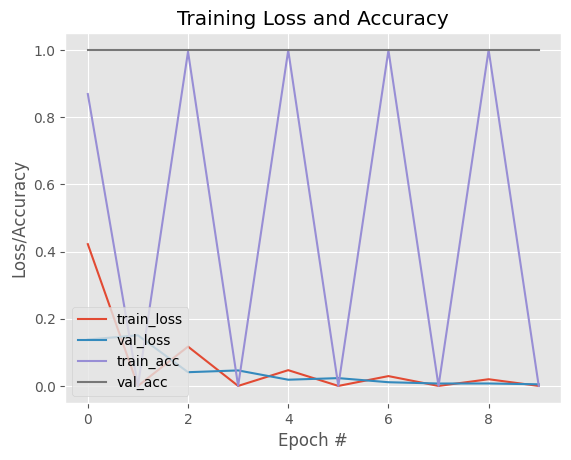

In [24]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")